<a href="https://colab.research.google.com/github/Hamid-Mofidi/PINNs_on_Multiple_timescale_dynamics/blob/main/Examples/Example2_3x3exact_sol_PINNs_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Solving a 3x3 system numerically (Comparing ODEint with the exact solution to obtain the error).

$$
\begin{aligned}
ɛ \frac{dx}{dt} =& - x,\\
ɛ \frac{dy}{dt} =&  2 y + ɛ x,\\
\frac{dz}{dt} =& x^2 + 1,
\end{aligned}
$$
where $ɛ$ is a small number. The above system is the slow system, but in the following code, I used the fast system.


In another code, I have the errors obtained by PINNs. I want to have a separate code with errors to compare the errors obtained by odeint with the errors obtained by PINNs in above to see which one works better.




[4.5399929762484854e-05, 0.0, 0.0]
Epoch 0, Loss: 0.06230847164988518
Epoch 1000, Loss: 2.2677290871797595e-06
Epoch 2000, Loss: 3.615741661633365e-07
Epoch 3000, Loss: 2.2899282612343086e-06
Epoch 4000, Loss: 7.828107584373356e-08
Epoch 5000, Loss: 9.939691381077864e-07
Epoch 6000, Loss: 6.494280313518175e-08
Epoch 7000, Loss: 7.087347597689586e-08
Epoch 8000, Loss: 1.2691939446085598e-06
Epoch 9000, Loss: 1.1754050177614772e-08
Epoch 0, Loss: 0.013450034894049168
Epoch 1000, Loss: 1.8479529444448417e-06
Epoch 2000, Loss: 1.5155994514959303e-10
Epoch 3000, Loss: 1.5014779697342107e-10
Epoch 4000, Loss: 1.4743593845789604e-10
Epoch 5000, Loss: 1.2831169016180866e-08
Epoch 6000, Loss: 1.2604536081539663e-08
Epoch 7000, Loss: 1.1360779872404692e-08
Epoch 8000, Loss: 9.433311021211921e-09
Epoch 9000, Loss: 8.278041363496413e-09


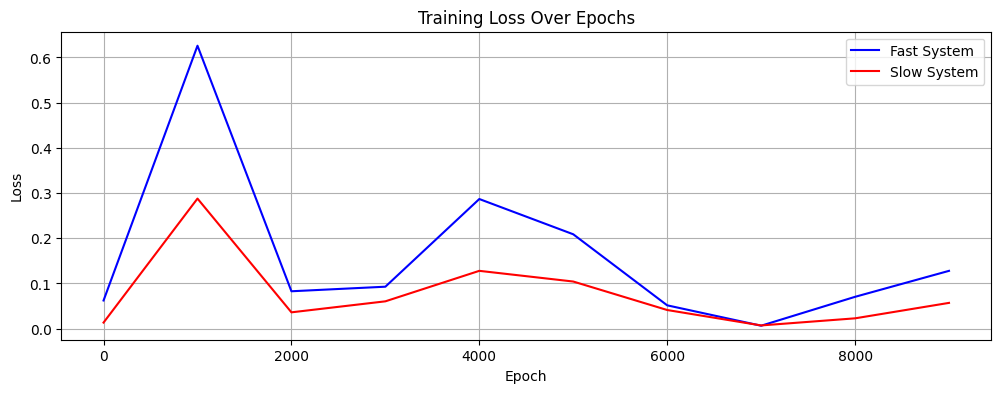

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import odeint

# Define the ODE system
def Fast_sub_system(y, t, eps):
    x, y, z = y
    dxdt = -x
    dydt = 2 * y
    dzdt = 0
    return [dxdt, dydt, dzdt]

def Slow_sub_system(y, tau, eps):
    x, y, z = y
    dzdtau = x**2 + 1
    return [dzdtau]

# Define the exact solution
def Fast_solution(t, eps, x0, y0, z0):
    x_real_fast = x0 * np.exp(-t)
    y_real_fast = y0 * np.exp(2 * t)
    z_real_fast = z0 * t
    return x_real_fast, y_real_fast, z_real_fast

def Slow_solution(tau, eps, x1, y1, z1):
    x_real_slow = 0 * tau
    y_real_slow = 0 * tau
    z_real_slow = tau + z1
    return x_real_slow, y_real_slow, z_real_slow

# Initial conditions
x0 = 1
y0 = 0
z0 = 0
t_end = 10
t  =  np.linspace(0, t_end, 100)
tau = np.linspace(0, 0.1, 100)
eps = 0.01

# Exact solution
x_exact_fast, y_exact_fast, z_exact_fast = Fast_solution(t, eps, x0, y0, z0)

# Get the final state of the fast system
x1, y1, z1 = x_exact_fast[-1], y_exact_fast[-1], z_exact_fast[-1]

print([x1,y1,z1])

# Exact solution for the slow system using the final state of the fast system as initial conditions
x_exact_slow, y_exact_slow, z_exact_slow = Slow_solution(tau, eps, x1, y1, z1)

# Transform to tensor
t_tensor = torch.tensor(t.reshape(-1, 1), dtype=torch.float32)
x_real_fast_tensor = torch.tensor(x_exact_fast.reshape(-1, 1), dtype=torch.float32)
y_real_fast_tensor = torch.tensor(y_exact_fast.reshape(-1, 1), dtype=torch.float32)
z_real_fast_tensor = torch.tensor(z_exact_fast.reshape(-1, 1), dtype=torch.float32)

tau_tensor = torch.tensor(tau.reshape(-1, 1), dtype=torch.float32)
x_real_slow_tensor = torch.tensor(x_exact_slow.reshape(-1, 1), dtype=torch.float32)
y_real_slow_tensor = torch.tensor(y_exact_slow.reshape(-1, 1), dtype=torch.float32)
z_real_slow_tensor = torch.tensor(z_exact_slow.reshape(-1, 1), dtype=torch.float32)

def input_transform(t_tensor):
    return torch.cat([t_tensor], dim=1)

class PINN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 300)
        self.fc2 = nn.Linear(300, 300)
        self.fc3 = nn.Linear(300, output_dim)

    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

# Define separate models for the fast and slow subsystems
model_fast = PINN(input_dim=1, output_dim=3)
model_slow = PINN(input_dim=1, output_dim=3)

def train_model(model, loss_func, optimizer, inputs, targets, epoch_num):
    loss_values = []
    for epoch in range(epoch_num):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_func(outputs, targets)
        loss.backward()
        optimizer.step()
        if epoch % 1000 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
        loss_values.append(loss.item())
    return loss_values

# Loss function for fast subsystem
def loss_func_fast(outputs, targets):
    return torch.mean((outputs - targets) ** 2)

# Loss function for slow subsystem
def loss_func_slow(outputs, targets):
    return torch.mean((outputs - targets) ** 2)

# Define optimizers for fast and slow subsystems
optimizer_fast = torch.optim.Adam(model_fast.parameters(), lr=1e-3)
optimizer_slow = torch.optim.Adam(model_slow.parameters(), lr=1e-3)

epoch_num = 10000

# Train the model for the fast subsystem
loss_values_fast = train_model(model_fast, loss_func_fast, optimizer_fast, t_tensor, torch.cat([x_real_fast_tensor, y_real_fast_tensor, z_real_fast_tensor], dim=1), epoch_num)

# Train the model for the slow subsystem
loss_values_slow = train_model(model_slow, loss_func_slow, optimizer_slow, tau_tensor, torch.cat([x_real_slow_tensor, y_real_slow_tensor, z_real_slow_tensor], dim=1), epoch_num)

# Plot loss curves for both subsystems
plt.figure(figsize=(12, 4))
plt.plot(range(0, epoch_num, 1000), loss_values_fast[:epoch_num // 1000], 'b', label='Fast System')
plt.plot(range(0, epoch_num, 1000), loss_values_slow[:epoch_num // 1000], 'r', label='Slow System')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


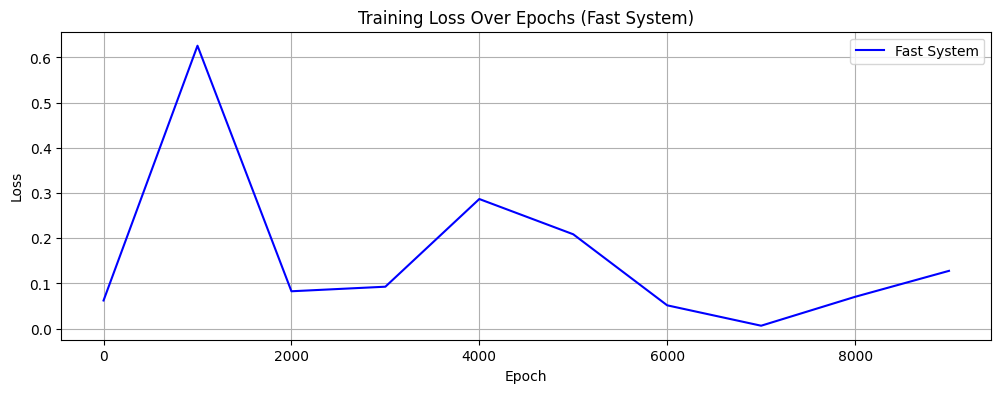

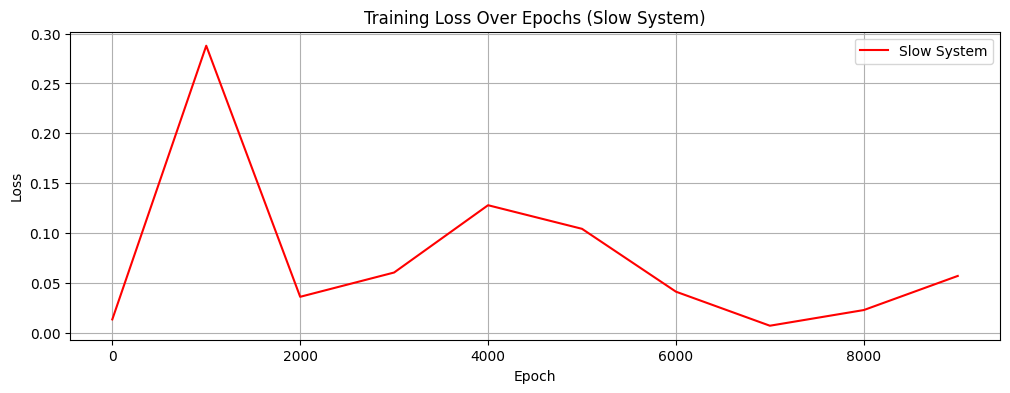

In [46]:
import matplotlib.pyplot as plt

# Plotting training loss over epochs
plt.figure(figsize=(12, 4))
plt.plot(range(0, epoch_num, 1000), loss_values_fast[:epoch_num//1000], 'b', label='Fast System')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs (Fast System)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(range(0, epoch_num, 1000), loss_values_slow[:epoch_num//1000], 'r', label='Slow System')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs (Slow System)')
plt.legend()
plt.grid(True)
plt.show()

# Model evaluation
model_fast.eval()
with torch.no_grad():
    # Predictions for fast system
    x_pred_fast, y_pred_fast, z_pred_fast = model_fast(t_tensor).numpy().T

model_slow.eval()
with torch.no_grad():
    # Predictions for slow system
    x_pred_slow, y_pred_slow, z_pred_slow = model_slow(tau_tensor).numpy().T


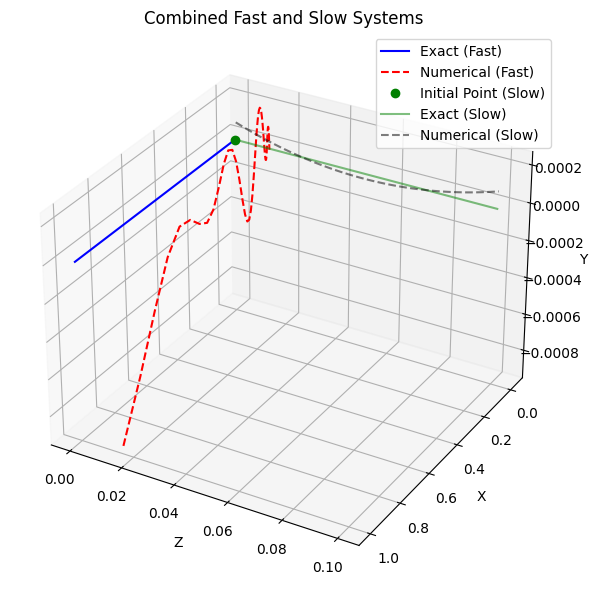

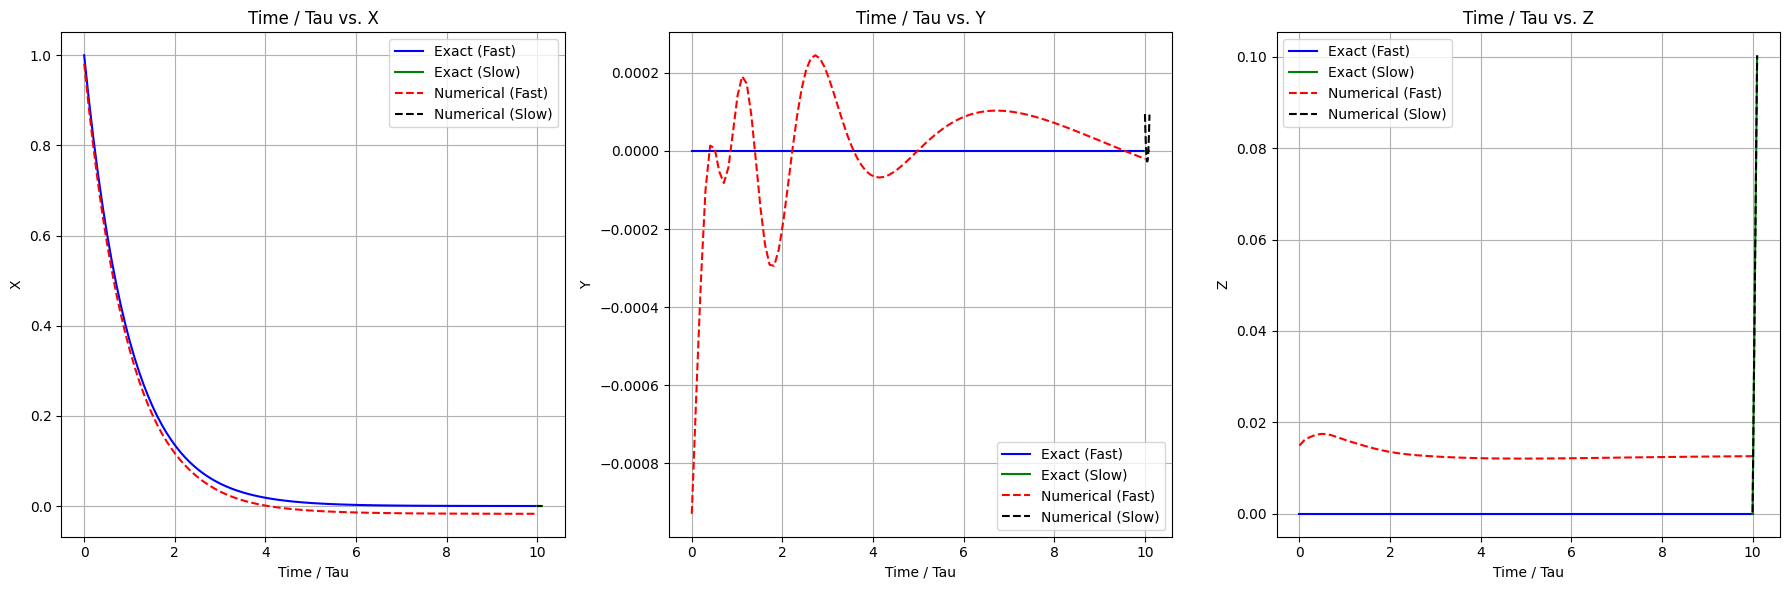

In [48]:
# Plotting the 3D trajectories
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')


# Plotting fast system
ax.plot(z_exact_fast, x_exact_fast, y_exact_fast, 'b-', label='Exact (Fast)')
ax.plot(z_pred_fast, x_pred_fast, y_pred_fast, 'r--', label='Numerical (Fast)')

# Plotting slow system continuation
ax.plot([z1], [x1], [y1], 'go', label='Initial Point (Slow)')


# Plotting slow system continuation
ax.plot(z_exact_slow, x_exact_slow, y_exact_slow, 'g-', label='Exact (Slow)', alpha=0.5)
ax.plot(z_pred_slow, x_pred_slow, y_pred_slow, 'k--', label='Numerical (Slow)', alpha=0.5)

ax.set_xlabel('Z')
ax.set_ylabel('X')
ax.set_zlabel('Y')
ax.set_title('Combined Fast and Slow Systems')
ax.legend()
ax.invert_yaxis()

plt.tight_layout()
plt.show()


import matplotlib.pyplot as plt

# Plotting time vs. state variables for both fast and slow systems
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plotting time vs. X for both fast and slow systems
axs[0].plot(t, x_exact_fast, 'b-', label='Exact (Fast)')
axs[0].plot(t_end + tau, x_exact_slow, 'g-', label='Exact (Slow)')
axs[0].plot(t, x_pred_fast, 'r--', label='Numerical (Fast)')
axs[0].plot(t_end + tau, x_pred_slow, 'k--', label='Numerical (Slow)')
axs[0].set_xlabel('Time / Tau')
axs[0].set_ylabel('X')
axs[0].set_title('Time / Tau vs. X')
axs[0].legend()
axs[0].grid(True)

# Plotting time vs. Y for both fast and slow systems
axs[1].plot(t, y_exact_fast, 'b-', label='Exact (Fast)')
axs[1].plot(t_end + tau, y_exact_slow, 'g-', label='Exact (Slow)')
axs[1].plot(t, y_pred_fast, 'r--', label='Numerical (Fast)')
axs[1].plot(t_end + tau, y_pred_slow, 'k--', label='Numerical (Slow)')
axs[1].set_xlabel('Time / Tau')
axs[1].set_ylabel('Y')
axs[1].set_title('Time / Tau vs. Y')
axs[1].legend()
axs[1].grid(True)

# Plotting time vs. Z for both fast and slow systems
axs[2].plot(t, z_exact_fast, 'b-', label='Exact (Fast)')
axs[2].plot(t_end + tau, z_exact_slow, 'g-', label='Exact (Slow)')
axs[2].plot(t, z_pred_fast, 'r--', label='Numerical (Fast)')
axs[2].plot(t_end + tau, z_pred_slow, 'k--', label='Numerical (Slow)')
axs[2].set_xlabel('Time / Tau')
axs[2].set_ylabel('Z')
axs[2].set_title('Time / Tau vs. Z')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

